In [25]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score, recall_score, precision_score, classification_report
import numpy as np

In [2]:
# Parameters
image_size = (224, 224)
batch_size = 32
data_dir = 'D:\\Beetle photos\\fingerprints'


In [3]:
# Helper function to extract class label from filename
def extract_class_label(filename):
    # Assuming the class label is the second part of the filename split by '_'
    return filename.split('_')[1]

# Load image paths and their corresponding class labels
image_paths = []
class_labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('_img.jpg'):
            image_paths.append(os.path.join(root, file))
            class_labels.append(extract_class_label(file))

# Encode class labels as integers
class_labels_unique = list(set(class_labels))
class_labels_to_idx = {label: idx for idx, label in enumerate(class_labels_unique)}
class_indices = [class_labels_to_idx[label] for label in class_labels]


In [42]:
class_labels_unique

['',
 'K16D-15',
 'K15M-05',
 'K16I-13',
 'K17G-03',
 '3M05',
 'L6B-20',
 'C10F03',
 'C4M05',
 'X2N-04',
 'K16C-10',
 'L6V-13',
 'K16P-10',
 'L4W-01',
 'C3M02',
 'L5Z-02',
 'C5M06',
 'C1CC-13',
 'C13M04',
 'L4Z-12',
 '13F02',
 '6M01',
 'C2M05',
 'C14M01',
 'C3M01',
 'L4V-12',
 'X2D-03',
 'K16I-23',
 'C5L-14',
 'L5K-13',
 'G11J-06',
 'C6H-05',
 'C2AL-22',
 'C2AL-12',
 '9M01',
 'K16B-21',
 'G2AG-07',
 'C15M03',
 'L5AP-11',
 'L6Q-04',
 'L4AA-27',
 'C4M04',
 'K16A-12',
 'C5L-22',
 'K17G-19',
 'G11L-02',
 'C6M01',
 'K16I-15',
 'C2AM-06',
 'K17B-04',
 '9F07',
 '10F07',
 'X2K-06',
 'K16N-10',
 'X2L-05',
 'K16B-16',
 'K16P-12',
 '7M03',
 'C7F01',
 '3M02',
 'L5D-10',
 'L6AA-08',
 'C16F04',
 'K16N-21',
 'C6H-20',
 '9M18',
 '5F07',
 'C13F02',
 'X2H-07',
 'K16N-23',
 'L5AP-10',
 '1F03',
 'X2J-08',
 'K16D-20',
 '7F01',
 'C3F09',
 'C9F05',
 'K16N-19',
 'G1AI-03',
 'X2M-01',
 '4M04',
 '11M10',
 'G11L-10',
 'L5F-21',
 'L5K-11',
 'L5L-06',
 '14F02',
 'G1AI-15',
 'G1AI-11',
 'L5G-10',
 '15M04',
 'K16O-1

In [43]:
class_indices

[654,
 455,
 490,
 737,
 43,
 1061,
 238,
 874,
 1057,
 586,
 321,
 384,
 101,
 203,
 237,
 659,
 178,
 544,
 383,
 843,
 89,
 321,
 513,
 6,
 1046,
 318,
 1012,
 572,
 666,
 168,
 806,
 310,
 255,
 694,
 320,
 695,
 95,
 1008,
 94,
 620,
 160,
 272,
 181,
 580,
 567,
 193,
 802,
 509,
 192,
 264,
 276,
 868,
 842,
 434,
 481,
 1077,
 61,
 493,
 712,
 205,
 652,
 791,
 376,
 177,
 1099,
 27,
 1011,
 376,
 919,
 299,
 185,
 636,
 64,
 1061,
 674,
 1046,
 930,
 47,
 45,
 1082,
 321,
 41,
 551,
 251,
 335,
 937,
 860,
 979,
 379,
 942,
 326,
 369,
 135,
 673,
 531,
 149,
 313,
 109,
 677,
 507,
 421,
 308,
 945,
 909,
 277,
 395,
 411,
 1085,
 2,
 1058,
 306,
 898,
 144,
 1015,
 973,
 594,
 1051,
 663,
 866,
 1041,
 170,
 139,
 904,
 406,
 874,
 1034,
 759,
 1058,
 291,
 470,
 517,
 1031,
 813,
 555,
 14,
 966,
 802,
 676,
 348,
 133,
 68,
 928,
 686,
 92,
 740,
 680,
 560,
 204,
 44,
 609,
 597,
 494,
 154,
 280,
 540,
 287,
 919,
 30,
 183,
 404,
 375,
 305,
 742,
 20,
 990,
 290,
 798,

In [4]:
# Create a DataFrame to facilitate resampling
import pandas as pd

data_df = pd.DataFrame({
    'image_path': image_paths,
    'class_index': class_indices
})

# Find the maximum number of samples in any class
max_samples = data_df['class_index'].value_counts().max()

# Resample each class to balance the dataset
balanced_data_df = pd.DataFrame()

for class_index in data_df['class_index'].unique():
    class_subset = data_df[data_df['class_index'] == class_index]
    class_resampled = resample(class_subset, replace=True, n_samples=max_samples, random_state=42)
    balanced_data_df = pd.concat([balanced_data_df, class_resampled])

# Shuffle the balanced dataset
balanced_data_df = balanced_data_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract image paths and class indices
image_paths = balanced_data_df['image_path'].tolist()
class_indices = balanced_data_df['class_index'].tolist()


In [5]:
# Count the number of samples for each class in the balanced dataset
class_counts = balanced_data_df['class_index'].value_counts()

# Check if all classes have the same number of samples
is_balanced = class_counts.min() == class_counts.max()

# Print class counts
print("Class Counts:")
print(class_counts)

# Print whether the dataset is balanced or not
print("\nIs the dataset balanced?", "Yes" if is_balanced else "No")


Class Counts:
class_index
654     67
777     67
1044    67
546     67
1038    67
        ..
702     67
1048    67
249     67
542     67
393     67
Name: count, Length: 1104, dtype: int64

Is the dataset balanced? Yes


In [6]:
# Split data into training, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, class_indices, test_size=0.3, stratify=class_indices, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)


In [7]:

# Data generator function
def data_generator(image_paths, labels, batch_size, is_train=True):
    data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2 if is_train else 0,
        zoom_range=0.2 if is_train else 0,
        horizontal_flip=True if is_train else False
    )
    
    while True:
        indices = np.arange(len(image_paths))
        if is_train:
            np.random.shuffle(indices)
        
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_indices = indices[start:end]
            batch_paths = [image_paths[i] for i in batch_indices]
            batch_labels = [labels[i] for i in batch_indices]
            batch_images = []
            
            for path in batch_paths:
                img = load_img(path, target_size=image_size)
                img_array = img_to_array(img)
                batch_images.append(img_array)
            
            batch_images = np.array(batch_images)
            batch_labels = to_categorical(batch_labels, num_classes=len(class_labels_unique))
            
            yield batch_images, batch_labels

# Create training, validation, and test generators
train_generator = data_generator(train_paths, train_labels, batch_size, is_train=True)
validation_generator = data_generator(val_paths, val_labels, batch_size, is_train=False)
test_generator = data_generator(test_paths, test_labels, batch_size, is_train=False)


In [8]:
# Load VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being updated during initial training
base_model.trainable = False

In [9]:

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce the feature maps to a single vector
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units
x = Dense(256, activation='relu')(x)  # Fully connected layer with 256 units
x = Dense(128, activation='relu')(x)  # Fully connected layer with 128 units
predictions = Dense(len(class_labels_unique), activation='softmax')(x)  # Output layer


In [10]:

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:


# Calculate steps per epoch
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(val_paths) // batch_size
test_steps = len(test_paths) // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), 
               ModelCheckpoint('best_model_before_finetuning.keras', save_best_only=True, monitor='val_loss')]
)

# Save the model before fine-tuning
model.save('model_before_finetuning_balanced_sgd.keras')




Epoch 1/10
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 10218s 6s/step - accuracy: 0.0091 - loss: 6.8797 - val_accuracy: 0.1502 - val_loss: 5.0011
Epoch 2/10
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 9260s 6s/step - accuracy: 0.3028 - loss: 4.1485 - val_accuracy: 0.7070 - val_loss: 1.6282
Epoch 3/10
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 9793s 6s/step - accuracy: 0.6863 - loss: 1.9200 - val_accuracy: 0.8323 - val_loss: 0.9136
Epoch 4/10
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 11034s 7s/step - accuracy: 0.8278 - loss: 1.0391 - val_accuracy: 0.8754 - val_loss: 0.6615
Epoch 5/10
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 9615s 6s/step - accuracy: 0.9012 - loss: 0.5123 - val_accuracy: 0.9025 - val_loss: 0.5092
Epoch 6/10
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 8688s 5s/step - accuracy: 0.9273 - loss: 0.3714 - val_accuracy: 0.9260 - val_loss: 0.4033
Epoch 7/10
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 31593s 20s/step - accuracy: 0.9419 - loss: 0.2834 - val_accuracy: 0.9383 - val_loss: 0.3300
Epoch 8/10
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 9187s 6s/step - accuracy: 0.95

In [12]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print(f'Test accuracy: {test_acc}')

346/346 ━━━━━━━━━━━━━━━━━━━━ 1613s 5s/step - accuracy: 0.9588 - loss: 0.2127
Test accuracy: 0.9569183588027954


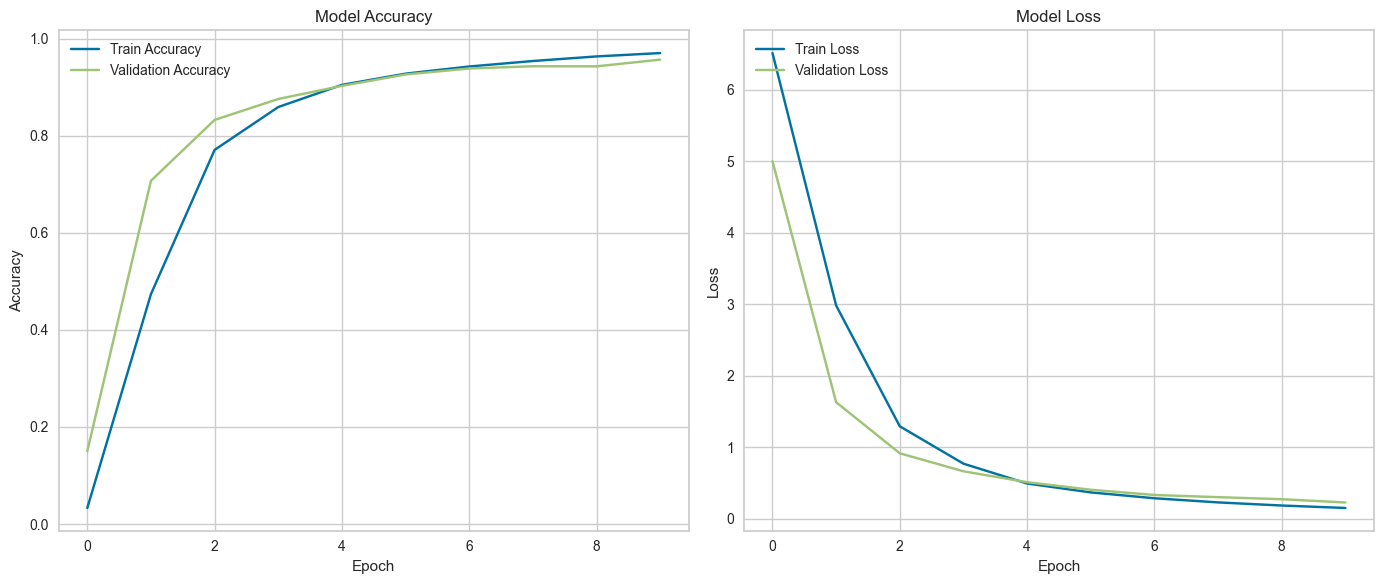

In [17]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(14, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(history)


In [28]:
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score, recall_score, precision_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC
from yellowbrick.contrib.wrapper import wrap
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

# Define a function to extract true labels from the generator
def extract_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, labels = next(generator)
        y_true.extend(np.argmax(labels, axis=1))
    return np.array(y_true)

# Create a new test generator instance to avoid exhaustion
test_generator_for_labels = data_generator(test_paths, test_labels, batch_size, is_train=False)
y_true = extract_true_labels(test_generator_for_labels, test_steps)

# Create a new test generator instance for predictions
test_generator_for_predictions = data_generator(test_paths, test_labels, batch_size, is_train=False)

# Predict the classes for the test data
y_pred = model.predict(test_generator_for_predictions, steps=test_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')
cohen_kappa = cohen_kappa_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Cohen Kappa Score: {cohen_kappa}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels_unique)
print("\nClassification Report:\n", report)




346/346 ━━━━━━━━━━━━━━━━━━━━ 1964s 6s/step


c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Preci

Accuracy: 0.9569183526011561
F1 Score: 0.955984371316065
Cohen Kappa Score: 0.9568792672078994
Recall: 0.9569183526011561
Precision: 0.9662808636737861

Classification Report:
               precision    recall  f1-score   support

                   0.83      1.00      0.91        10
     K16D-15       1.00      0.80      0.89        10
     K15M-05       0.90      1.00      0.95         9
     K16I-13       1.00      0.90      0.95        10
     K17G-03       1.00      1.00      1.00        10
        3M05       1.00      1.00      1.00        10
      L6B-20       1.00      1.00      1.00        10
      C10F03       1.00      1.00      1.00        10
       C4M05       1.00      1.00      1.00         9
      X2N-04       1.00      1.00      1.00        10
     K16C-10       1.00      1.00      1.00        10
      L6V-13       1.00      1.00      1.00        10
     K16P-10       1.00      1.00      1.00        10
      L4W-01       1.00      1.00      1.00        11
       C3M02

YellowbrickTypeError: This estimator is not a classifier; try a regression or clustering score visualizer instead!